# PDC project - Channel Model

In [1]:
import numpy as np
import bitarray
import matplotlib.pyplot as plt

## Serialization

In [2]:
def string_to_bits(s):
    ba = bitarray.bitarray()
    ba.frombytes(s.encode('utf-8'))
    nparray = np.array(list(ba))
    return np.where(nparray == 0, -1, nparray)

In [3]:
def bits_to_string(bs):
    return bitarray.bitarray(list(np.where(bs == -1, 0, bs))).tobytes().decode('utf-8')

## Convolutional Encoding

### Convolutional Encoder

In [4]:
def convolutional_encoder(bs):
    bs = np.append([1, 1], bs)
    bs = np.append(bs, [1,1])
    codewords = []
    
    for i in range(2, len(bs)):
        codewords.append(bs[i]*bs[i-2])
        codewords.append(bs[i]*bs[i-1]*bs[i-2])
        
    return np.array(codewords)

In [5]:
def encoder(bs, repeat):
    if repeat % 3 != 0 and repeat != 1:
        raise Exception('repeat arg. has to be a multiple of 3 or 1.')
    codewords = convolutional_encoder(bs)
    return np.repeat(codewords, repeat)

### Erasure Detection

In [6]:
def detect_erasure(dec_ys):
    bins = np.sum(np.abs(dec_ys), axis=1)
    mods = []
    for i in range(3):
        mods.append(np.sum(bins[i::3]))
    return np.argmin(mods)

In [7]:
def remove_erasures(ys, repeat):
    dec_ys = [ys[i::repeat] for i in range(repeat)]
    mod = detect_erasure(dec_ys)
    return [dec_ys[i] for i in range(repeat) if i % 3 != mod]

### Convolutional Decoder

In [8]:
def to_dec(alpha):
    return int(str(alpha[0]) + str(alpha[1]), 2)

In [9]:
def convolutional_decoder(ys):
    
    maxj = len(ys)//2 + 1
    alphas = [set() for _ in range(maxj)]
    alphas[0] = {(1,1)}
    
    transitions = {
        
        (0,0): {
            (0,0): {
                'bit': -1,
                'cw': (1,-1)
            },
            (1,0): {
                'bit': 1,
                'cw': (-1,1)
            }
        },
        
        (0,1): {
            (0,0): {
                'bit': -1,
                'cw': (-1,1)
            },
            (1,0): {
                'bit': 1,
                'cw': (1,-1)
            }
        },
        
        (1,0): {
            (0,1): {
                'bit': -1,
                'cw': (1,1)
            },
            (1,1): {
                'bit': 1,
                'cw': (-1,-1)
            }
        },
        
        (1,1): {
            (0,1): {
                'bit': -1,
                'cw': (-1,-1)
            },
            (1,1): {
                'bit': 1,
                'cw': (1,1)
            }
        }
    }
    
    paths = [[list() for _ in range(4)] for _ in range(maxj)]
    paths_cost = [[-np.inf for _ in range(4)] for _ in range(maxj)]
    paths_cost[0][to_dec((1,1))] = 0 
    
    for j in range(1, maxj):        
        for alpha in alphas[j-1]:
            for beta in [(0, alpha[0]), (1, alpha[0])]:
                
                x = transitions[alpha][beta]['cw']
                
                edge_cost = x[0]*ys[2*j-1-1] + x[1]*ys[2*j-1]
                subpath_cost = paths_cost[j-1][to_dec(alpha)]
                cost = edge_cost + subpath_cost
                
                alphas[j].add(beta)
                
                if cost > paths_cost[j][to_dec(beta)]:
                    paths_cost[j][to_dec(beta)] = cost
                    paths[j][to_dec(beta)] = paths[j-1][to_dec(alpha)] + [transitions[alpha][beta]['bit']]
                
    return paths[maxj-1][to_dec((1,1))][:-2]

In [10]:
def decoder_old(ys, repeat):
    if repeat % 3 != 0 and repeat != 1:
        raise Exception('repeat arg. has to be a multiple of 3 or 1.')
    
    yss = remove_erasures(ys, repeat)
    dec = []
    res = []
    
    for ys in yss:
        dec.append(convolutional_decoder(ys))
    
    for bitvotes in np.transpose(dec):
        bins = np.bincount(np.where(bitvotes == -1, 0, bitvotes))
        bit = np.argmax(bins)
        bit = bit if bit == 1 else -1
        res.append(int(bit))

    return dec[0]

In [11]:
def decoder(ys, repeat):
    if repeat % 3 != 0 and repeat != 1:
        raise Exception('repeat arg. has to be a multiple of 3 or 1.')
    
    yss = remove_erasures(ys, repeat)
    ys = np.sum(yss, axis=0)

    return convolutional_decoder(ys)

## Server Pipeline

In [12]:
def encode(filename, repeat):
    file = open(filename, 'r')
    data = file.read()
    file.close()
    
    bits = string_to_bits(data)
    xs = encoder(bits, 3)
    np.savetxt(filename[:-4] + '-encoded.txt', xs)
    
    return bits

In [13]:
def decode(filename, repeat):
    ys = np.loadtxt(filename)
    bits = decoder(ys, repeat)
    #data = bits_to_string(np.array(bits))
    
    file = open(filename[:-4] + '-decoded.txt', 'w')
    file.write(data)
    file.close()
    
    return bits

## Channel Models

In [14]:
def silent_channel(chanInput):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput, erasedIndex

In [15]:
def noisy_channel(chanInput, var = 10):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput + np.sqrt(var)*np.random.randn(len(chanInput)), erasedIndex

In [16]:
def noisy_soft_channel(chanInput, var = 10):
    return chanInput + np.sqrt(var)*np.random.randn(len(chanInput))

---
# Test section

## Serialization

In [17]:
data = open('files/input.txt', 'r').read()

In [18]:
bits_to_string(string_to_bits(data))

"Ceci est un test. Je m'appelle Antoine et j'écris des accents pour faire des tests.\n😀\n"

## Erasure detection

In [19]:
data = open('files/input.txt', 'r').read()
bits = string_to_bits(data)

In [20]:
def detect_erasure_test(channel, repeats = 30, iters = 100):
    errors = {}
    logs = {}
    
    for rep in range(3, repeats, 3):
        xs = np.repeat(bits, rep)

        loc_err = 0
        loc_logs = {}

        for i in range(iters):
            xsi, ei = channel(xs)
            dec_xsi = [xsi[i::rep] for i in range(rep)]
            mod = detect_erasure(dec_xsi)
            if ei != mod:
                loc_err += 1
                loc_logs[i] = {
                    'xs': xsi,
                    'dec_xs': dec_xsi,
                    'ei': ei,
                    'mod': mod
                }

        errors[rep] = loc_err
        logs[rep] = loc_logs
    
    return errors, logs

### Over silent channel

In [21]:
errors, _ = detect_erasure_test(silent_channel, 15, 100)

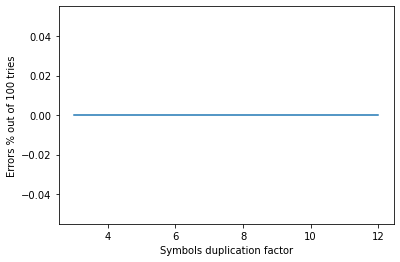

In [22]:
plt.plot(list(errors.keys()), list(errors.values()))
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {100} tries')
plt.show()

### Over noisy channel

In [23]:
repeats, iters = 60, 300
errors, logs = detect_erasure_test(noisy_channel, repeats, iters)

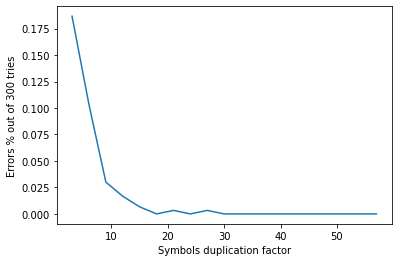

In [24]:
plt.plot(list(errors.keys()), np.array(list(errors.values()))/iters)
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {iters} tries')
plt.show()

## Convolutional Encoding


In [25]:
ys_book = [1,3,-2,1,4,-1,5,5,-3,-3,1,-6,2,-4]
res_book = convolutional_decoder(ys_book)
print(res_book)

[1, 1, 1, 1, -1]


In [26]:
xs_test = encoder([1,1,-1,1], 1)
res_test = convolutional_decoder(xs_test)
print(res_test)

[1, 1, -1, 1]


In [27]:
xs_test_1 = [1,1,-1,1,1,-1,-1,1,1,-1,1,1,-1]
xs_test_2 = [1,1,1,-1,-1,1,1,-1,1,1,-1,1,1,-1,-1,-1,1,-1,1]
res_test_1 = convolutional_decoder(encoder(xs_test_1,1))
res_test_2 = convolutional_decoder(encoder(xs_test_2,1))
print(xs_test_1 == res_test_1 and xs_test_2 == res_test_2)

True


## Convolutional Encoding Pipeline

In [28]:
hey = "Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀"

In [29]:
rep = 39
bts = string_to_bits(hey)
enc = encoder(bts, rep)
out = noisy_channel(enc, 10)[0]
res = decoder(out, rep)
print(f'Block usage: {len(enc)} ({len(enc) / 60000})')
bits_to_string(np.array(res))

Block usage: 50700 (0.845)


"Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀"

### Statistics

In [37]:
log = {}
bts = string_to_bits(hey)

for rep in range(3, 48, 3):
    print(rep, end='\r')
    log[rep] = {}
    for i in range(50):
        enc = encoder(bts, rep)
        out = noisy_channel(enc, 10)[0]
        dec = decoder(out, rep)
        
        try:
            res =  bits_to_string(np.array(dec))
        except UnicodeDecodeError as err:
            res = 'error'
        
        log[rep][i] = {
            'usage': len(enc),
            'percent': len(enc) / 60000,
            'string': res,
            'bin-acc': 1 if res == hey else 0
        }

In [38]:
log[3]

{0: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 1: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 2: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 3: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 4: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 5: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 6: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 7: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 8: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 9: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 10: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 11: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 12: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bin-acc': 0},
 13: {'usage': 3900, 'percent': 0.065, 'string': 'error', 'bi

In [45]:
acc = 0
errs = {}
for i in range(50):
    acc += log[45][i]['bin-acc']
    if log[45][i]['bin-acc'] != 1:
        errs[i] = log[39][i]['string']

In [46]:
acc / 50

0.9

In [47]:
print(f'Chance to fail: {(1-(acc / 50))**2}')

Chance to fail: 0.009999999999999995


In [51]:
log[45][0]['usage']

58500

In [54]:
hey == errs[18]

True

In [49]:
errs

{1: "Hey. J'écris des Accents pour faire des tests et j'aime la pêche. Bonsoir. 😀",
 18: "Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀",
 19: "Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀",
 24: "Hey. J'écris dds accents pour faire des tests et j'aime la pêche. Bonsoir. 😀",
 34: "Hey. J'écris des accents pour faire des tests et j'aime la pêche. Bonsoir. 😀"}

## Server Pipeline

---
# *TODO*

- Finir conv. decoder ***DONE***
- Se poser sur le système de votes ***DONE***
- Find optimal *repeat* parameter ***DONE***


- Pipeline server (easy) ***DONE***
- Tester pipeline server ***DONE***


- Faire des vrais tests avec zero noise ***DONE***
- Faire des vrais tests avec peu noise local
- Faire des vrais tests avec real noise local